In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
import importlib

try:
    importlib.reload(dda)
except NameError:
    import dd_analysis as dda
    
try:
    importlib.reload(dd)
except NameError:
    import disjoint_domain as dd

In [1]:
batchsize_runs = {
    'B5': 'data/batchsize/batch5_dd_res_2020-12-29_16-37-09.npz',
    'B10': 'data/batchsize/batch10_dd_res_2020-12-29_17-28-34.npz',
    'B15': 'data/batchsize/batch15_dd_res_2020-12-29_18-10-11.npz',
    'B16': 'data/batchsize/batch16_dd_res_2020-12-23_16-48-15.npz',
    'B20': 'data/batchsize/batch20_dd_res_2020-12-29_18-30-34.npz',
    'B25': 'data/batchsize/batch25_dd_res_2020-12-29_18-44-56.npz',
    'B30': 'data/batchsize/batch30_dd_res_2020-12-29_18-59-20.npz',
    'B31': 'data/batchsize/batch31_dd_res_2020-12-29_15-04-17.npz',
    'B32': 'data/batchsize/batch32_dd_res_2020-12-23_16-13-07.npz',
    'B35': 'data/batchsize/batch35_dd_res_2020-12-29_19-10-51.npz',
    'B40': 'data/batchsize/batch40_dd_res_2020-12-29_19-22-28.npz',
    'B45': 'data/batchsize/batch45_dd_res_2020-12-29_19-31-13.npz',
    'B50': 'data/batchsize/batch50_dd_res_2020-12-29_19-40-00.npz',
    'B55': 'data/batchsize/batch55_dd_res_2020-12-29_19-49-22.npz',
    'B60': 'data/batchsize/batch60_dd_res_2020-12-29_20-07-49.npz',
    'B64': 'data/batchsize/batch64_dd_res_2020-12-23_15-59-45.npz',
    'B65': 'data/batchsize/batch65_dd_res_2020-12-29_20-17-04.npz'
}

In [76]:
domain_holdout_runs = {
    'original -> original': 'data/domain_ho_eqdist_dd_res_2020-12-24_14-56-49.npz',
    'original -> equidistant': 'data/domain_ho_orig_dd_res_2020-12-25_09-29-54.npz',
    'original -> 3-3-2': 'data/domain_ho_332_dd_res_2020-12-27_07-40-26.npz',
    'original -> 5-1-2': 'data/domain_ho_512_from_orig_dd_res_2021-01-03_11-43-15.npz',
    
    'equidistant -> original': 'data/domain_ho_orig_from_eqdist_dd_res_2021-01-02_06-57-29.npz',
    'equidistant -> equidistant': 'data/domain_ho_eqdist_from_eqdist_dd_res_2021-01-01_21-47-45.npz',
    'equidistant -> 3-3-2': 'data/domain_ho_332_from_eqdist_dd_res_2021-01-02_16-15-20.npz',
    'equidistant -> 5-1-2': 'data/domain_ho_512_from_eqdist_dd_res_2021-01-04_02-04-41.npz',
    
    '3-3-2 -> original': 'data/domain_ho_orig_from_332_dd_res_2020-12-31_02-11-40.npz',
    '3-3-2 -> equidistant': 'data/domain_ho_eqdist_from_332_dd_res_2020-12-30_20-25-13.npz',
    '3-3-2 -> 3-3-2': 'data/domain_ho_332_from_332_dd_res_2020-12-31_07-28-31.npz',
    '3-3-2 -> 5-1-2': 'data/domain_ho_512_from_332_dd_res_2021-01-03_18-39-16.npz',
    
    '5-1-2 -> original': 'data/domain_ho_orig_from_512_dd_res_2021-01-04_06-53-28.npz',
    '5-1-2 -> equidistant': 'data/domain_ho_eqdist_from_512_dd_res_2021-01-04_15-05-25.npz',
    '5-1-2 -> 3-3-2': 'data/domain_ho_332_from_512_dd_res_2021-01-04_12-36-34.npz',
    '5-1-2 -> 5-1-2': 'data/domain_ho_512_from_512_dd_res_2021-01-03_04-48-33.npz'
}

In [2]:
simple_domain_holdout_runs = {
    'original => original': 'data/simple_domain_ho/orig_from_orig_dd_res_2021-08-11_19-09-03.npz',
    'original => equidistant': 'data/simple_domain_ho/eqdist_from_orig_dd_res_2021-08-11_19-50-03.npz',
    'original => 3-3-2': 'data/simple_domain_ho/332_from_orig_dd_res_2021-08-11_21-34-27.npz',
    'original => 5-1-2': 'data/simple_domain_ho/512_from_orig_dd_res_2021-08-11_22-57-21.npz',
    
    'equidistant => original': 'data/simple_domain_ho/orig_from_eqdist_dd_res_2021-08-12_13-25-54.npz',
    'equidistant => equidistant': 'data/simple_domain_ho/eqdist_from_eqdist_dd_res_2021-08-12_16-20-01.npz',
    'equidistant => 3-3-2': 'data/simple_domain_ho/332_from_eqdist_dd_res_2021-08-12_18-42-53.npz',
    'equidistant => 5-1-2': 'data/simple_domain_ho/512_from_eqdist_dd_res_2021-08-12_20-35-28.npz',
    
    '3-3-2 => original': 'data/simple_domain_ho/orig_from_332_dd_res_2021-08-12_22-37-28.npz',
    '3-3-2 => equidistant': 'data/simple_domain_ho/eqdist_from_332_dd_res_2021-08-12_23-30-34.npz',
    '3-3-2 => 3-3-2': 'data/simple_domain_ho/332_from_332_dd_res_2021-08-13_01-50-16.npz',
    '3-3-2 => 5-1-2': 'data/simple_domain_ho/512_from_332_dd_res_2021-08-13_03-41-42.npz',
    
    '5-1-2 => original': 'data/simple_domain_ho/orig_from_512_dd_res_2021-08-13_05-44-59.npz',
    '5-1-2 => equidistant': 'data/simple_domain_ho/eqdist_from_512_dd_res_2021-08-13_06-33-54.npz',
    '5-1-2 => 3-3-2': 'data/simple_domain_ho/332_from_512_dd_res_2021-08-13_08-42-32.npz',
    '5-1-2 => 5-1-2': 'data/simple_domain_ho/512_from_512_dd_res_2021-08-13_10-34-13.npz'
}

In [4]:
simple_dho_runs_repeat_attrs = {
    'original ==> original': 'data/simple_domain_ho_repeat_attrs/orig_from_orig_dd_res_2021-08-05_18-57-10.npz',
    'original ==> equidistant': 'data/simple_domain_ho_repeat_attrs/eqdist_from_orig_dd_res_2021-08-05_19-26-44.npz',
    'original ==> 3-3-2': 'data/simple_domain_ho_repeat_attrs/332_from_orig_dd_res_2021-08-05_20-42-45.npz',
    'original ==> 5-1-2': 'data/simple_domain_ho_repeat_attrs/512_from_orig_dd_res_2021-08-05_21-41-50.npz',
    
    'equidistant ==> original': 'data/simple_domain_ho_repeat_attrs/orig_from_eqdist_dd_res_2021-08-05_23-15-50.npz',
    'equidistant ==> equidistant': 'data/simple_domain_ho_repeat_attrs/eqdist_from_eqdist_dd_res_2021-08-06_02-05-52.npz',
    'equidistant ==> 3-3-2': 'data/simple_domain_ho_repeat_attrs/332_from_eqdist_dd_res_2021-08-06_03-43-58.npz',
    'equidistant ==> 5-1-2': 'data/simple_domain_ho_repeat_attrs/512_from_eqdist_dd_res_2021-08-06_04-58-49.npz',
    
    '3-3-2 ==> original': 'data/simple_domain_ho_repeat_attrs/orig_from_332_dd_res_2021-08-06_06-06-50.npz',
    '3-3-2 ==> equidistant': 'data/simple_domain_ho_repeat_attrs/eqdist_from_332_dd_res_2021-08-06_06-34-02.npz',
    '3-3-2 ==> 3-3-2': 'data/simple_domain_ho_repeat_attrs/332_from_332_dd_res_2021-08-06_07-46-33.npz',
    '3-3-2 ==> 5-1-2': 'data/simple_domain_ho_repeat_attrs/512_from_332_dd_res_2021-08-06_08-43-41.npz',
    
    '5-1-2 ==> original': 'data/simple_domain_ho_repeat_attrs/orig_from_512_dd_res_2021-08-06_09-48-24.npz',
    '5-1-2 ==> equidistant': 'data/simple_domain_ho_repeat_attrs/eqdist_from_512_dd_res_2021-08-06_10-13-01.npz',
    '5-1-2 ==> 3-3-2': 'data/simple_domain_ho_repeat_attrs/332_from_512_dd_res_2021-08-06_11-19-02.npz',
    '5-1-2 ==> 5-1-2': 'data/simple_domain_ho_repeat_attrs/512_from_512_dd_res_2021-08-06_12-12-53.npz'
}

In [155]:
intergroup_runs = {
    'intergroup near -> near': 'data/intergroup/near_to_near_dd_res_2021-01-10_10-55-52.npz',
    'intergroup near -> far': 'data/intergroup/near_to_far_dd_res_2021-01-11_01-40-33.npz',
    'intergroup far -> near': 'data/intergroup/far_to_near_dd_res_2021-01-11_11-13-03.npz',
    'intergroup far -> far': 'data/intergroup/far_to_far_dd_res_2021-01-12_13-54-22.npz'
}

In [22]:
# Load data from previous runs

try:
    curr_load_settings = load_settings
except NameError:
    curr_load_settings = {}
    
load_settings = {
    'dist_metric': 'correlation',
    'calc_all_repr_dists': False,
    'include_individual_rdms': False,
    'subsample_snaps': 1
}

curr_res_paths = {}
if load_settings == curr_load_settings:
    try:
        curr_res_paths = res_paths
    except NameError:
        res_data = {}
else:
    res_data = {}
    
res_paths = {
    'Original': 'data/dd_res_2020-12-03_01-31-32.npz',
#     'Shared repr.': 'data/merged_repr_dd_res_2020-12-04_05-15-35.npz',
#     'Small item repr': 'data/small_item_repr_dd_res_2020-11-24_18-48-00.npz',
#     'More compressed': 'data/all_ratios_0.5_dd_res_2020-11-24_21-17-07.npz',
#     'Half-size HL': 'data/half_hidden_longer_dd_res_2020-11-25_01-06-37.npz',
#     'Merged item repr.': 'data/no_item_repr_reallocate_dd_res_2020-12-04_06-30-32.npz',
#     'Merged context repr.': 'data/no_ctx_repr_reallocate_dd_res_2020-12-04_07-48-18.npz',
#     'All merged': 'data/no_repr_reallocate_dd_res_2020-12-03_03-24-49.npz',
#     'One domain': 'data/1domain_dd_res_2020-12-14_12-57-53.npz',
#     'Original (small init)': 'data/4domain_small_init_dd_res_2020-12-23_00-34-01.npz',
#     'One domain (small init)': 'data/1domain_small_init_dd_res_2020-12-23_00-52-41.npz',
#     **batchsize_runs,
#     **domain_holdout_runs,
#     **simple_domain_holdout_runs,
#     **simple_dho_runs_repeat_attrs,
#     'Original no reuse': 'data/original_no_reuse_dd_res_2021-01-06_17-15-11.npz',
#     '4-4 equal': 'data/4-4_dd_res_2021-01-05_14-16-02.npz',
#     '4-4 no reuse': 'data/4-4_no_reuse_dd_res_2021-01-06_14-51-28.npz',
#     '4-4 unequal': 'data/4-4_unequal_dd_res_2021-01-06_19-37-51.npz',
#     '4-4 equal independent': 'data/44_dho_dd_res_2021-01-09_06-31-41.npz',
#     'Original independent': 'data/422_dho_dd_res_2021-01-09_21-57-46.npz',
#      **intergroup_runs,
#     'Original (new)': 'data/original_new_dd_res_2021-01-12_20-21-39.npz',
#     'Fixed biases': 'data/fixed_biases_dd_res_2021-01-12_20-30-39.npz',
#     'All merged fixed biases': 'data/all_merged_fixed_biases_44_dd_res_2021-01-15_13-26-57.npz',
#     '2domain test': 'data/2domain_weight_test_dd_res_2021-01-15_15-19-33.npz',
#     'All merged 2 groups': 'data/all_merged_2group_dd_res_2021-01-18_15-12-35.npz',
#     'All merged 3-3-2': 'data/all_merged_332_dd_res_2021-01-18_15-18-12.npz',
#     'All merged 5-1-2': 'data/all_merged_512_dd_res_2021-01-18_15-24-33.npz',
#     'Original longer': 'data/original_longer_dd_res_2021-07-22_01-25-47.npz',
#     'Repeated attrs': 'data/repeated_attrs_longer_dd_res_2021-07-22_03-11-12.npz',
    'Clustered, unequal freq.': 'data/dissoc/simple_lowerlr_structured_uneq_freq_dd_res_2021-08-11_12-44-14.npz',
    'Clustered, equal freq.': 'data/dissoc/simple_lowerlr_structured_eq_freq_dd_res_2021-08-11_13-12-12.npz',
    'Flat, equal freq.': 'data/dissoc/simple_lowerlr_unstructured_eq_freq_dd_res_2021-08-11_13-39-58.npz',
    'Flat, unequal freq.': 'data/dissoc/simple_lowerlr_unstructured_uneq_freq_dd_res_2021-08-11_14-07-54.npz',
#     'Dissoc. net, orig': 'data/dissoc/simple_orig_dd_res_2021-08-09_20-57-19.npz',
#     'Dissoc. orig weightdrop': 'data/dissoc/simple_orig_weightdrop_dd_res_2021-08-10_00-58-28.npz',
#     'Dissoc. orig lowerlr': 'data/dissoc/simple_orig_lower_lr_dd_res_2021-08-10_23-19-32.npz',
#     'Dissoc. orig lowerlr2': 'data/dissoc/simple_orig_lower_lr2_dd_res_2021-08-11_00-39-02.npz',
#     'Merged ctx, 1 ctx/domain': 'data/merged_ctx_repr_1ctx_nopadding_dd_res_2021-07-29_14-24-47.npz',
#     'Merged ctx, 1 ctx/domain, padded': 'data/merged_ctx_repr_1ctx_dd_res_2021-07-29_13-31-08.npz',
#     'Identity activations': 'data/merged_ctx_1ctx_id_act_dd_res_2021-07-29_17-59-18.npz',
#     'No context': 'data/no_ctx_dd_res_2021-07-29_21-27-10.npz',
#     'No context, no biases': 'data/no_ctx_no_bias_dd_res_2021-07-30_10-48-23.npz',
#     'All merged, no ctx no biases': 'data/all_merged_no_bias_dd_res_2021-08-02_11-56-29.npz',
#     'No reprs, same size HL': 'data/short_save_params_no_repr_dd_res_2020-11-26_12-11-26.npz',
#     'One domain': 'data/combo_1domain_dd_res_2021-08-10_12-48-04.npz',
}

# Avoid reloading data whenever possible
try:
    res_data = {name: (res_data[name] if name in curr_res_paths and curr_res_paths[name] == path
                else dda.get_result_means(path, **load_settings))
                for name, path in res_paths.items()}
except:
    # Assume loading failed, revert
    res_paths = curr_res_paths
    raise

C:\Users\ethan\.conda\envs\cuda11\lib\site-packages\scipy\stats\_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\ethan\.conda\envs\cuda11\lib\site-packages\scipy\stats\_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [23]:
# Get ready to look at some particular runs
# curr_runs = ['Merged item repr.', 'Merged context repr.', 'All merged', 'Shared repr.']
# curr_runs = ['Original independent', '4-4 equal independent']
# curr_runs = [name for name in res_paths if name[0] == 'B' and int(name[1:]) % 5 == 0] # batch size runs
# curr_runs = res_paths.keys()
# curr_runs = intergroup_runs.keys()
# curr_runs = ['Original (new)', 'All merged', 'All merged 3-3-2', 'All merged 5-1-2']
# curr_runs = ['No context', 'No context, no biases'] #, 'All merged, no ctx no biases']
# curr_runs = ['Original longer', 'Repeated attrs']
curr_runs = ['Clustered, unequal freq.', 'Clustered, equal freq.', 'Flat, unequal freq.', 'Flat, equal freq.']
# curr_runs = ['Dissoc. net, orig', 'Dissoc. orig lowerlr', 'Dissoc. orig lowerlr2', 'No context, no biases']
# curr_runs = ['4-4 unequal', '4-4 equal independent']
# curr_runs = ['Original_new', 'Merged_item_new', 'Merged_ctx_new', 'One domain']
# curr_runs = ['Original']

cluster_types = ['original', 'equidistant', '3-3-2', '5-1-2']
# arrow types (hacky): -> = old/full network, => = simplified network w/ separately generated attrs,
# ==> = simplified network w/ repeated attrs across domains
# curr_runs = [c1 + ' => ' + c2 for c1 in cluster_types for c2 in cluster_types]
# curr_runs = [f'{c} => {c}' for c in cluster_types] # just use one of each trained type

curr_sets = {name: res_data[name] for name in curr_runs if name in res_data.keys()}
n_curr = len(curr_runs)

# colors supposed to correspond to accuracy in original generalization test (deprecated)
#prop_cycle = cycler(color=['chocolate', 'yellowgreen', 'royalblue', 'fuchsia', 'orangered'])

# general cycle that supports up to 40 lines
col_cycle = plt.rcParams['axes.prop_cycle']
line_cycle = cycler(linestyle=['-', '--', ':', '-.'])
prop_cycle = line_cycle * col_cycle[:4]
# line_cols = col_cycle[:3].by_key()['color']
# marker_cycle = cycler(mfc=line_cols, mec=line_cols)
# prop_cycle = marker_cycle * col_cycle[:3]

plt.close('all')

In [49]:
# Plot attribute dendrograms
fig, axs = dda.make_plot_grid(len(curr_sets), 2, ax_dims=(5, 3), ravel=True)
for ax, (label, res) in zip(axs, curr_sets.items()):
    dd.plot_item_attribute_dendrogram(ax=ax, metric='cityblock', **res['net_params'])
    ax.set_title(f'Item attribute distance ({label})')

fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
# Plot loss, accuracy, and test accuracy
plot_types = ['loss', 'weighted_acc'] #, 'test_weighted_acc'] #, 'etg_domain']
fig, axs = dda.make_plot_grid(len(plot_types) + 4,
                              1, ax_dims=(9, 3),
                              ravel=True, prop_cycle=prop_cycle)

for i, (label, res) in enumerate(curr_sets.items()):
    for ax, ptype in zip(axs, plot_types):
        dda.plot_report(ax, res, ptype, label=label)
        
    etg_ax = axs[2 + i % len(cluster_types)]
    type1 = label.split()[0]
    type2 = label.split()[-1]
    if type1 == type2:
        linewidth = 2
    else:
        linewidth = 0.25
    dda.plot_report(etg_ax, res, 'etg_domain', label=label, lw=linewidth)

for ax in axs[:2]:
    dda.outside_legend(ax, fontsize='x-small', ncol=2)

for ax in axs[2:]:
    ax.legend(ncol=2)
    ax.set_xlabel('Epochs training domains 1-3')
    ax.set_ylabel('Epochs to 85% on 4th domain')
    curr_ylims = ax.get_ylim()
    ax.set_ylim((curr_ylims[0], curr_ylims[1] * 1.2))

fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

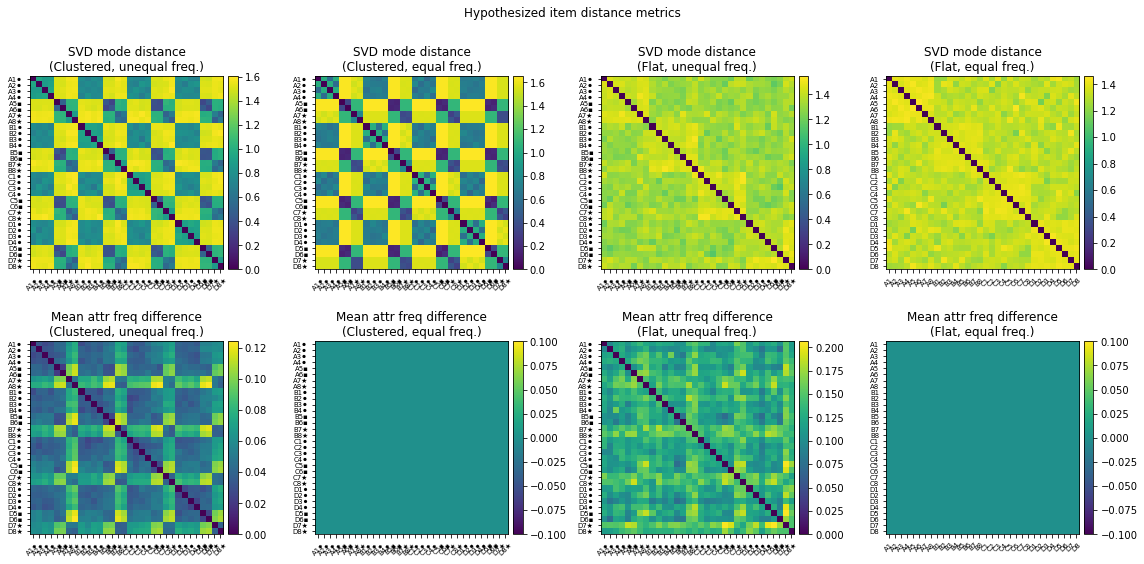

In [35]:
# Plot hypothesized item distance measures on training data that representation distances may correspond to
dist_fns = [dda.get_svd_dist_mats, dda.get_attr_freq_dist_mats]
dist_fn_names = ['SVD mode distance', 'Mean attr freq difference']

fig, axss = dda.auto_subplots(len(dist_fns), n_curr)
fig.suptitle('Hypothesized item distance metrics')

for fn, fn_name, axs in zip(dist_fns, dist_fn_names, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        dist_mats = fn(res)
        input_names = dda._get_names_for_snapshots('item', **res['net_params'])
        im = dda.plot_matrix_with_labels(ax, np.mean(dist_mats, axis=0), input_names)
        ax.set_title(f'{fn_name}\n({label})')
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize('x-small')

fig.tight_layout(rect=(0, 0, 1, 0.98))
# fig.canvas.layout.width = '1300px'
plt.show()

In [42]:
# axs[2].set_xscale('log')
# axs[2].get_legend().remove()
# ylims = axs[2].get_ylim()
# snap_epochs = curr_sets['Original']['snap_epochs']
# for ind in [0, 1, 5, 10, 50, 100]:
#     epoch = snap_epochs[ind]
#     axs[2].plot([epoch, epoch], ylims, 'k--')

# plt.show()

In [69]:
# Item RSA matrices

# this and commented parts are for plotting just one run rather than the mean
run_num = 0

inds_to_plot = np.arange(30)
# layers = ['item', 'item_hidden']
layer_names = {'item': 'Item repr.', 'item_hidden': 'Hidden'}
layer = 'item_hidden'
fig, axss = dda.auto_subplots(len(inds_to_plot), n_curr, ax_dims=(3,3))
# fig, axss = dda.auto_subplots(len(layers), len(inds_to_plot))
# fig.suptitle(f'Mean {load_settings["dist_metric"]} distance') # for {layer}') #, run {run_num}')

# for layer, axs in zip(layers, axss):
for ind, axs in zip(inds_to_plot, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):            
#         label = 'Original'
        res = curr_sets[label]
#     for layer, ax in zip(layers, axs):
        dda.plot_rsa(ax, res, layer, ind, title_addon=f'{label}, {layer_names[layer]}') # ,
#                       rsa_mat=res['repr_dists']['item_full']['snaps_each'][run_num, ind])
        for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
            ticklabel.set_fontsize('x-small')

fig.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
# Plot regressors for quantitative analysis of item correlations
dist_fns = [lambda x: dda.get_svd_dist_mats(x, normalize=True),
            lambda x: dda.get_attr_freq_dist_mats(x, normalize=True) - dda.get_svd_dist_mats(x, normalize=True)]
dist_fn_names = ['SVD mode distance (normalized)', 'Attr freq difference (normalized) - \n SVD mode distance (normalized)']

fig, axss = dda.auto_subplots(len(dist_fns), n_curr)
fig.suptitle('Item distance regressors')

for fn, fn_name, axs in zip(dist_fns, dist_fn_names, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        dist_mats = fn(res)
        input_names = dda._get_names_for_snapshots('item', **res['net_params'])
        im = dda.plot_matrix_with_labels(ax, np.mean(dist_mats, axis=0), input_names)
        ax.set_title(f'{fn_name}\n({label})')
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize('x-small')

fig.tight_layout(rect=(0, 0, 1, 0.98))
fig.canvas.layout.width = '1300px'
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [182]:
# Show attribute frequency measure (to compare to above RDMs)
run_num = 0
#train_items = slice(24)
train_items=slice(None)

fig, axs = dda.make_plot_grid(n_curr, n_curr, ax_dims=(3.5, 3.5))
for (label, res), ax in zip(curr_sets.items(), axs):
    attr_freq_dist = dda.get_attr_freq_dist_mats(res, train_items=train_items)
    input_names = dda._get_names_for_snapshots('item_full', **res['net_params'])
    dda.plot_matrix_with_labels(ax, attr_freq_dist[run_num], input_names[train_items])
    ax.set_title(f'{label}, run {run_num}')
    
fig.suptitle('Attribute frequency similarity')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'Attribute frequency similarity')

In [152]:
# Try correlating attribute frequency measure to RDMs
fig, ax = plt.subplots(figsize=(8, 4))
for label, res in curr_sets.items():
    dda.plot_attr_freq_dist_correlation(ax, res, label=label, train_items=train_items)
    
ax.set_xlim([0, 2001])
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [47]:
# Dendrograms for just original
fig, axs = dda.auto_subplots(1, len(inds_to_plot), ax_dims=(4.5, 3.5))
for ind, ax in zip(inds_to_plot, axs.ravel()):
    dda.plot_repr_dendrogram(ax, curr_sets['Original'], 'item', ind)
    
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
# Corresponding dendrograms
fig, axss = dda.auto_subplots(len(inds_to_plot), n_curr, ax_dims=(4, 3))
fig.suptitle('Item representation similarity')

for ind, axs in zip(inds_to_plot, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        dda.plot_repr_dendrogram(ax, res, 'item_hidden', ind, title_addon=label)

fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
# Look at RSA projections onto group, domain, and item models
# First plot the models
item_models = dda.make_ortho_item_rsa_models(**next(iter(curr_sets.values()))['net_params'])

fig, axs = dda.auto_subplots(1, (len(item_models)), ax_dims=(3.4, 3.4))
for ax, (mtype, model) in zip(axs.ravel(), item_models.items()):
    dda.plot_rsa_model(ax, model, input_type='item')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize('x-small') 
    ax.set_title(mtype + ' model RDM')
    
# fig.canvas.layout.width = '1300px'
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AssertionError: Wrong number of labels

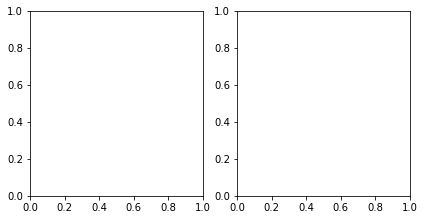

In [12]:
# Context hidden layer projections
# First plot models
ctx_models = dda.make_ortho_context_rsa_models(**next(iter(curr_sets.values()))['net_params'])

fig, axs = dda.auto_subplots(1, len(ctx_models), ax_dims=(3.4, 3.4))
for ax, (mtype, model) in zip(axs.ravel(), ctx_models.items()):
    dda.plot_rsa_model(ax, model, input_type='context')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize('x-small') 
    ax.set_title(mtype + ' model RDM')
    
fig.tight_layout()
plt.show()

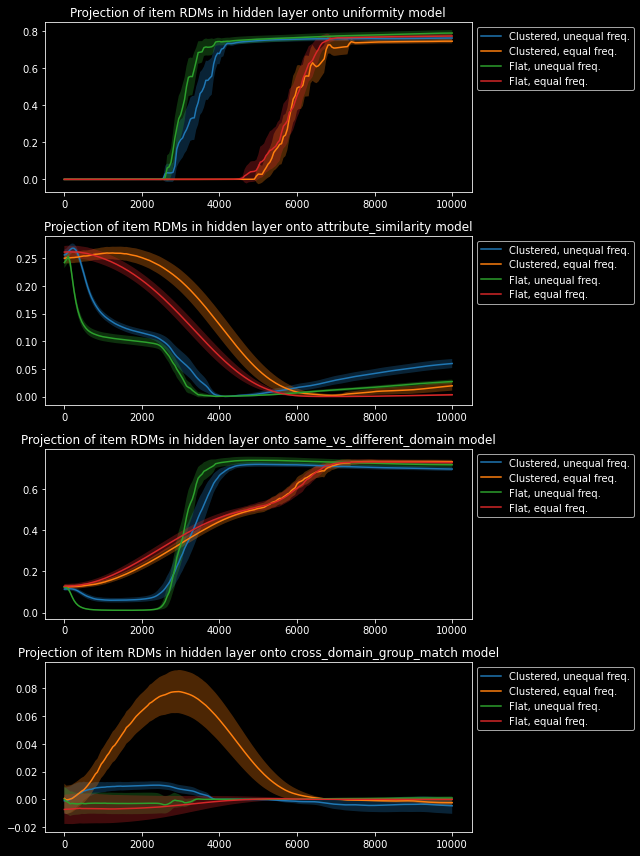

In [27]:
def plot_snap_projections(snap_type):
    n_plots = len(item_models) if 'item' in snap_type else len(ctx_models)
    fig, axs = dda.make_plot_grid(n_plots, 1, ax_dims=(9, 3),
                                  ravel=True, prop_cycle=prop_cycle)

    for label, res in curr_sets.items():
        if snap_type in res['repr_dists']:
            dda.plot_rdm_projections(res, snap_type, axs, label=label)

    for ax in axs:
        dda.outside_legend(ax)

    fig.tight_layout()
    plt.show()

# Item hidden layer projections
plot_snap_projections('item_hidden')

In [6]:
# Try correlating each 2x2 item_hidden corr matrix with individual SVD and/or attr freq distance, as applicable
colors = [d['color'] for d in list(col_cycle)]
linestyles = ['-', '--']

fig, ax = plt.subplots()
ax.set_title(f'Correlation of hidden-layer item {load_settings["dist_metric"]} \n' +
             'distances with SVD and attribute frequency models')

def get_model_corrs(res, svd=True, attr_freq=True):
    models = dict()
    if svd:
        models['svd'] = dda.center_and_norm_rdm(
            np.mean(dda.get_svd_dist_mats(res), axis=0))
    if attr_freq:
        models['attr_freq'] = dda.center_and_norm_rdm(
            np.mean(dda.get_attr_freq_dist_mats(res), axis=0))
    return dda.get_rdm_projections(res, snap_type='item_hidden', models=models)

def plot_corr_ci(res, corr, label, color, style):
    mean, (lower, upper) = dda.get_mean_and_ci(corr)
    ax.plot(res['snap_epochs'], mean, label=label, color=color, linestyle=style)
    ax.fill_between(res['snap_epochs'], lower, upper, alpha=0.3, color=color, linestyle=style)

# clustered, unequal freq.
res = curr_sets['Clustered, unequal freq.']
clust_uneq_corrs = get_model_corrs(res, svd=True, attr_freq=True)
plot_corr_ci(res, clust_uneq_corrs['svd'], 'Clustered, unequal freq. - SVD',
             colors[0], linestyles[0])
plot_corr_ci(res, clust_uneq_corrs['attr_freq'], 'Clustered, unequal freq. - attr. freq.',
             colors[0], linestyles[1])

# clustered, equal freq.
res = curr_sets['Clustered, equal freq.']
clust_eq_corrs = get_model_corrs(res, svd=True, attr_freq=False)
plot_corr_ci(res, clust_eq_corrs['svd'], 'Clustered, equal freq. - SVD',
             colors[1], linestyles[0])

# flat, unequal freq.
res = curr_sets['Flat, unequal freq.']
flat_uneq_corrs = get_model_corrs(res, svd=False, attr_freq=True)
plot_corr_ci(res, flat_uneq_corrs['attr_freq'], 'Flat, unequal freq. - attr. freq.',
             colors[2], linestyles[1])

ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
# Item representation layer projections
plot_snap_projections('item')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
# All layers item projection
plot_snap_projections('item_full')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [90]:
# Context hidden layer projections
plot_snap_projections('context_hidden')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [91]:
# Context representation layer projections
plot_snap_projections('context')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
# All layers context projection
plot_snap_projections('context_full')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# special analysis of projections onto cross_domain_group_match model to look at batch size
batch_sizes = np.array([res['train_params']['batch_size'] for res in curr_sets.values()])
projections = np.stack([np.mean(dda.get_rdm_projections(res, snap_type='item_full')['cross_domain_group_match'], axis=0)
                        for res in curr_sets.values()])

fig, ax = plt.subplots(figsize=(8, 6))
ax.matshow(projections)
ax.set_title('Strength of cross-domain (checkerboard) pattern')
ax.set_yticks(range(projections.shape[0]))
ax.set_yticklabels(batch_sizes)
ax.set_ylabel('Batch size')
ax.set_xticks(range(0, projections.shape[1], 4))
ax.set_xticklabels(curr_sets['B5']['snap_epochs'][::4])
ax.set_xlabel('Training epoch')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [100]:
# Fit linear models
reg_data = dda.make_dict_for_regression(curr_sets.values())

In [94]:
# Fit model for context domain information interacting with item domain and attribute similarity (both potentially important)
model1_res = dda.fit_linear_model('test_weighted_acc ~ ctx_same_vs_different_domain*(item_attribute_similarity + item_same_vs_different_domain)', reg_data)
print(model1_res.summary())

                            OLS Regression Results                            
Dep. Variable:      test_weighted_acc   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     5971.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:46:18   Log-Likelihood:                 21863.
No. Observations:               18180   AIC:                        -4.371e+04
Df Residuals:                   18174   BIC:                        -4.367e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [101]:
model2_res = dda.fit_linear_model('test_weighted_acc ~ item_attribute_similarity + ctx_same_vs_different_domain', reg_data)
print(model2_res.summary())

                            OLS Regression Results                            
Dep. Variable:      test_weighted_acc   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     7451.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:36:17   Log-Likelihood:                 18472.
No. Observations:               18180   AIC:                        -3.694e+04
Df Residuals:                   18177   BIC:                        -3.691e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
# TODO: Try plotting a combination of item attribute similarity and context domain measures? Not sure if it makes sense.

In [74]:
# Context RSA matrix
inds_to_plot = [0, 1, 4, 11, 12, 30, 50, -1]
fig, axss = dda.auto_subplots(len(inds_to_plot), n_curr, ax_dims=(4, 4))
fig.suptitle('Mean RSA for contexts')

#ctx_sets = {name: res for name, res in curr_sets.items() if name in ['Original', 'Merged repr', 'No item repr']}

for ind, axs in zip(inds_to_plot, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        dda.plot_rsa(ax, res, 'context_hidden', ind, title_addon=label, item_order='domain-inner')

fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
# Corresponding context dendrograms
fig, axss = dda.auto_subplots(len(inds_to_plot), n_curr, ax_dims=(4, 3))
fig.suptitle('Context representation similarity')

for ind, axs in zip(inds_to_plot, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        dda.plot_repr_dendrogram(ax, res, 'context', ind, title_addon=label)

fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [79]:
# Item rep RSA over all snapshots (useful maybe for finding interesting change points)
fig, axs = dda.make_plot_grid(len(curr_sets), 2, ax_dims=(5, 5))

for ax, (label, res) in zip(axs, curr_sets.items()):
    n_snaps = len(res['snap_epochs'])
    snap_freq = res['train_params']['snap_freq']
    im = ax.imshow(res['repr_dists']['item']['all'],
                   extent=(-0.5, n_snaps * snap_freq-0.5, n_snaps * snap_freq-0.5, -0.5))
    ax.set_xticks(res['snap_epochs'][::4])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yticks(res['snap_epochs'][::4])
    ax.set_xlabel('Epochs')
    ax.set_title(f'Item repr distances over training ({label})')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [62]:
# MDS of item representations over time
for label, res in curr_sets.items():
    dda.plot_repr_trajectories(res, 'item', dims=3, title_label=label)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
for label, res in curr_sets.items():
    dda.plot_repr_trajectories(res, 'item_hidden', dims=3, title_label=label)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
import importlib
importlib.reload(dda)

fig, axs = dda.make_plot_grid(len(curr_runs), 2, ax_dims=(6, 15))
run_num = 0
snap_index = 5

for (name, res), ax in zip(short_sets.items(), axs.ravel()):
    dda.plot_hl_input_pattern_correlations(ax, res, run_num, snap_index, title_label=name)
    
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …